In [19]:
import os

import pandas as pd

from torch.utils.data import DataLoader

from trajectory_prediction.utils import (
    TrajBatchSampler,
    TrajectoryDataset,
    traj_collate_fn,
)

root = "../.."

In [4]:
# Load the train and test data from the original TrajNet dataset
df_train = pd.read_pickle(os.path.join(root, "datasets/sdd_trajnet/original/train_trajnet.pkl"))
df_test = pd.read_pickle(os.path.join(root, "datasets/sdd_trajnet/original/test_trajnet.pkl"))

# Log the information of the train and test dataframe
print(f"Train dataframe shape: {df_train.shape}")
print(f"Test dataframe shape: {df_test.shape}")

df_train.head()

Train dataframe shape: (169880, 6)
Test dataframe shape: (56580, 6)


,frame,trackId,x,y,sceneId,metaId
0,0,100,757.0,918.5,bookstore_0,0
1,12,100,765.0,918.5,bookstore_0,0
2,24,100,773.0,918.5,bookstore_0,0
3,36,100,780.5,918.5,bookstore_0,0
4,48,100,788.5,919.5,bookstore_0,0


In [8]:
# List all scenes
scenes = df_train["sceneId"].unique()
print(f"Number of scenes: {len(scenes)}")

# Log all scenes
print(f"Scenes: {scenes}")

Number of scenes: 30
Scenes: ['bookstore_0' 'bookstore_1' 'bookstore_2' 'bookstore_3' 'coupa_3'
 'deathCircle_0' 'deathCircle_1' 'deathCircle_2' 'deathCircle_3'
 'deathCircle_4' 'gates_0' 'gates_1' 'gates_3' 'gates_4' 'gates_5'
 'gates_6' 'gates_7' 'gates_8' 'hyang_4' 'hyang_5' 'hyang_6' 'hyang_7'
 'hyang_9' 'nexus_0' 'nexus_1' 'nexus_3' 'nexus_4' 'nexus_7' 'nexus_8'
 'nexus_9']


### Take one scene as an example

In [10]:
scene_name = "bookstore_0"
scene_data = df_train[df_train["sceneId"] == scene_name]
print(f"Scene data shape: {scene_data.shape}")

# Log the first few rows of the scene data
print("Scene data first few rows:")
scene_data.head()

Scene data shape: (16100, 6)
Scene data first few rows:


,frame,trackId,x,y,sceneId,metaId
0,0,100,757.0,918.5,bookstore_0,0
1,12,100,765.0,918.5,bookstore_0,0
2,24,100,773.0,918.5,bookstore_0,0
3,36,100,780.5,918.5,bookstore_0,0
4,48,100,788.5,919.5,bookstore_0,0


In [12]:
def convert_and_save_tracking_data(df, output_folder, filename='tracking_data.txt'):
    """
    Convert tracking dataframe to the specified format and save as txt file.
    
    Args:
        df: Pandas DataFrame containing tracking data with columns [frame, trackId, x, y, sceneId, metaId]
        output_folder: Folder path to save the output txt file
        filename: Name of the output txt file
    """
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Sort by frame first, then by metaId (agent id)
    sorted_df = df.sort_values(by=['frame', 'metaId'])

    # Group by frame
    grouped = sorted_df.groupby('frame')

    # Open file for writing
    output_path = os.path.join(output_folder, filename)
    with open(output_path, 'w') as f:
        # Process each frame group
        for frame, group in grouped:
            # For each agent in this frame
            for _, row in group.iterrows():
                # Write frame, agent_id (metaId), x, y as tab-separated values
                f.write(f"{row['frame']}\t{row['metaId']}.0\t{row['x']/100:.2f}\t{row['y']/100:.2f}\n")

    print(f"Conversion complete. File saved to {output_path}")
    return output_path

In [17]:
output_path = convert_and_save_tracking_data(
    df=scene_data,
    output_folder=os.path.join(root, "datasets/sdd_trajnet/processed/"),
    filename=f"{scene_name}.txt"
)

Conversion complete. File saved to ../../datasets/sdd_trajnet/processed/bookstore_0.txt


In [21]:
# Load and test the converted tracking data
dataset_dir = os.path.join(root, "datasets/sdd_trajnet/processed/")
obs_len = 8
pred_len = 12
batch_size = 32

dataset = TrajectoryDataset(
    data_dir=dataset_dir,
    obs_len=obs_len,
    pred_len=pred_len,
)
sampler = TrajBatchSampler(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
dataloader = DataLoader(
    dataset,
    batch_sampler=sampler,
    collate_fn=traj_collate_fn,
    pin_memory=True
)

batch = next(iter(dataloader))
print(f"Batch shape: {batch[0].shape}")
print(f"Batch shape: {batch[1].shape}")

Batch shape: torch.Size([33, 8, 2])
Batch shape: torch.Size([33, 12, 2])


### Process the whole dataset

In [22]:
for scene_name in scenes:
    scene_data = df_train[df_train["sceneId"] == scene_name]

    output_path = convert_and_save_tracking_data(
        df=scene_data,
        output_folder=os.path.join(root, "datasets/sdd_trajnet/processed/"),
        filename=f"{scene_name}.txt"
    )

Conversion complete. File saved to ../../datasets/sdd_trajnet/processed/bookstore_0.txt
Conversion complete. File saved to ../../datasets/sdd_trajnet/processed/bookstore_1.txt
Conversion complete. File saved to ../../datasets/sdd_trajnet/processed/bookstore_2.txt
Conversion complete. File saved to ../../datasets/sdd_trajnet/processed/bookstore_3.txt
Conversion complete. File saved to ../../datasets/sdd_trajnet/processed/coupa_3.txt
Conversion complete. File saved to ../../datasets/sdd_trajnet/processed/deathCircle_0.txt
Conversion complete. File saved to ../../datasets/sdd_trajnet/processed/deathCircle_1.txt
Conversion complete. File saved to ../../datasets/sdd_trajnet/processed/deathCircle_2.txt
Conversion complete. File saved to ../../datasets/sdd_trajnet/processed/deathCircle_3.txt
Conversion complete. File saved to ../../datasets/sdd_trajnet/processed/deathCircle_4.txt
Conversion complete. File saved to ../../datasets/sdd_trajnet/processed/gates_0.txt
Conversion complete. File save

In [35]:
from trajectory_prediction.utils import load_limited_data_per_scene

all_inputs, all_targets = load_limited_data_per_scene(
    dataset_dir, "test", obs_len, pred_len, samples_per_scene=10
)


Load data from 29 scene files, each scene limited to 10 samples
Processing scene: nexus_1
Loaded 10 samples from scene nexus_1
Processing scene: gates_4
Loaded 10 samples from scene gates_4
Processing scene: coupa_3
Loaded 10 samples from scene coupa_3
Processing scene: hyang_7
Loaded 2 samples from scene hyang_7
Processing scene: bookstore_0
Loaded 10 samples from scene bookstore_0
Processing scene: deathCircle_4
Loaded 1 samples from scene deathCircle_4
Processing scene: nexus_3
Loaded 10 samples from scene nexus_3
Processing scene: gates_6
Loaded 3 samples from scene gates_6
Processing scene: nexus_4
Loaded 10 samples from scene nexus_4
Processing scene: hyang_6
Loaded 10 samples from scene hyang_6
Processing scene: gates_5
Loaded 5 samples from scene gates_5
Processing scene: gates_1
Loaded 10 samples from scene gates_1
Processing scene: deathCircle_0
Loaded 10 samples from scene deathCircle_0
Processing scene: gates_7
Loaded 3 samples from scene gates_7
Processing scene: hyang_5
L

In [38]:
for traj_idx, (input_traj, target_traj) in enumerate(zip(all_inputs, all_targets)):
    print(input_traj.shape)
    print(target_traj.shape)
    break

(3, 8, 2)
(3, 12, 2)


Batch first instance:


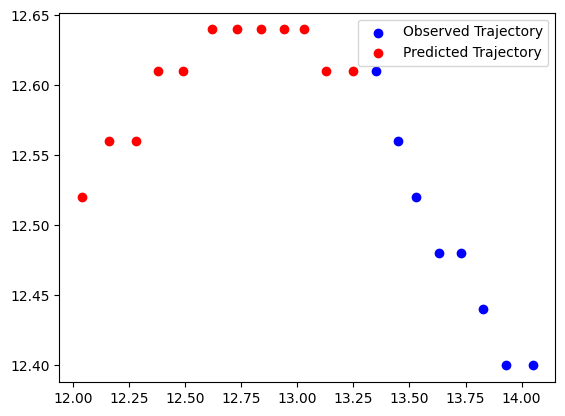

In [37]:
# Visualize one instance in the batch
print("Batch first instance:")

instance_observation = input_traj[0] # [8, 2]
instance_prediction = target_traj[0] # [12, 2]

import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots()

ax.scatter(instance_observation[:, 0], instance_observation[:, 1], c='blue', label='Observed Trajectory')
ax.scatter(instance_prediction[:, 0], instance_prediction[:, 1], c='red', label='Predicted Trajectory')

ax.legend()
plt.show()